In [1]:
import os
import pandas as pd
import numpy as np
import gzip
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from article_dataset import ArticleDataset

from transformers import BertForSequenceClassification


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import BertTokenizerFast as BertTokenizer

In [4]:
LABEL = 'major_topic_pred_index'
ARTICLE = 'article'

In [5]:
def read_folder(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl.gz'):
            with gzip.open(os.path.join(folder_path, filename), 'rt', encoding='utf-8') as file:
                for line in file:
                    json_data = json.loads(line)
                    df = pd.DataFrame(json_data)
                    dataframes.append(df)
    if dataframes:
        aggregated_df = pd.concat(dataframes, ignore_index=True)
        return aggregated_df
    else:
        print("No jsonl files found in the directory.")
        return None
    
def reduce(_number=6):
    # csak a test
    test = os.path.join(os.getcwd(), 'test')
    df = read_folder(test)
    df.drop('uuid', axis=1, inplace=True)
    return df.groupby('major_topic_pred').apply(lambda x: x.sample(n=min(_number, len(x)))).reset_index(drop=True)


df_train = reduce(6)
df_test = reduce(3)
df_eval = reduce(3)

print(df_train.index)
print(df_test.index)
print(df_eval.index)

labels = df_train['major_topic_pred'].unique().tolist()
number_of_labels = len(labels)
id_to_label = {_id: label for _id, label in enumerate(labels)}
label_to_id = {label: _id for _id, label in enumerate(labels)}


df_train["major_topic_pred_index"] = df_train['major_topic_pred'].map(lambda x: label_to_id[x])
df_test["major_topic_pred_index"] = df_test['major_topic_pred'].map(lambda x: label_to_id[x])
df_eval["major_topic_pred_index"] = df_eval['major_topic_pred'].map(lambda x: label_to_id[x])

df_eval.info()

RangeIndex(start=0, stop=132, step=1)
RangeIndex(start=0, stop=66, step=1)
RangeIndex(start=0, stop=66, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   66 non-null     object 
 1   lead                    66 non-null     object 
 2   article                 66 non-null     object 
 3   domain                  66 non-null     object 
 4   url                     66 non-null     object 
 5   date_of_creation        63 non-null     object 
 6   cc_date                 66 non-null     object 
 7   tags                    66 non-null     object 
 8   doc_similarity          66 non-null     float64
 9   major_topic_pred        66 non-null     int64  
 10  major_topic_pred_index  66 non-null     int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 5.8+ KB


In [6]:
df_train.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Felére csökkent a Volkswagen nyeresége,A Volkswagen harmadik negyedéves nyeresége köz...,A gyár nettó profitja 439 millió euróra csökke...,origo.hu,https://www.origo.hu/gazdasag/hirek/20021030fe...,2002-10-30T11:07:00,2019-05-27T12:36:13,nyereség,0.823234,1,0
1,Varga Mihály visszaszólt az eurót pocskondiázó...,Szigorításokkal fogná vissza a készpénzhasznál...,"Azt szeretné a kormány, ha a mostaninál több n...",hvg.hu,https://hvg.hu/gazdasag/20191106_Varga_Mihaly_...,2019-11-06T06:41:00,2021-01-27T21:03:17,versenyképességi tanács,0.811978,1,0
2,Hatalmas deficittel birkózik az USA,Az Egyesült Államok költségvetési hiánya idén ...,"A kormány költségvetési hivatala 2010-re 1,47 ...",index.hu,http://index.hu/gazdasag/vilag/2010/07/27/hata...,2010-07-27T06:53:00,2017-11-20T00:40:35,egyesült államok,0.731257,1,0
3,"Bod Péter Ákos: Válság után, válságok előtt","Mit válthat ki egy újabb gazdasági krízis, és ...","Gazdaságról ma nem beszélhetünk úgy, hogy ne r...",hvg.hu,https://hvg.hu/gazdasag/201841_beszelgetesek__...,2018-10-15T11:00:00,2019-01-21T16:38:12,Bod Péter Ákos,0.721534,1,0
4,"Putyin elismerte, megszorítások jöhetnek","„Nem lehet válságról beszélni” Putyin szerint,...","„Nem hiszem, hogy válságról beszélhetünk” – mo...",origo.hu,https://www.origo.hu/gazdasag/20141218-putyin-...,2014-12-18T15:59:00,2020-09-30T04:13:35,válság,0.701693,1,0


In [7]:
df_test.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Az üzleti szféra üzenete Orbánnak: első a gazd...,A gazdasági érdekvédelmi szervezetek vezetői m...,"Legelőször is a gazdaságot kell rendbe hozni, ...",hvg.hu,https://hvg.hu/gazdasag/20100510_uzleti_szfera...,2010-05-11T06:30:00,2020-08-05T22:42:30,MKIK,0.560493,1,0
1,Gyenge teljesítmény a francia ipari óriástól,A cég nettó nyeresége március 31-ével zárult ü...,A cég nettó nyeresége március 31-ével zárult ü...,hvg.hu,https://hvg.hu/kkv/20110504_alstom/nyomtatas,2011-05-04T12:06:00,2021-02-28T21:06:29,Alstom eredmény,0.867125,1,0
2,Az üzleti szféra üzenete Orbánnak: első a gazd...,A gazdasági érdekvédelmi szervezetek vezetői m...,"Legelőször is a gazdaságot kell rendbe hozni, ...",hvg.hu,https://hvg.hu/gazdasag/20100510_uzleti_szfera...,2010-05-11T06:30:00,2020-08-05T22:42:30,Német-Magyar Ipari és Kereskedelmi Kamara,0.560493,1,0
3,Lecigányozzák az utcán Béci párját a VV-sztár ...,"Béci párja, Adrienn zaklatásnak van kitéve.","A lány nemrég elárulta, már a buszon is lecigá...",kisalfold.hu,http://www.kisalfold.hu/szorakozas/leciganyozz...,2011-03-11T09:45:00,2017-03-26T12:12:27,bulvárketrec,0.405999,2,1
4,Megtalálták a legendák hatalmas folyóját,"Miért omlott össze az ókor egyik legnagyobb, d...",Az Indus-völgyi kultúra - más néven Harappa-ci...,origo.hu,http://www.origo.hu/tudomany/20120529-indus-ha...,2012-05-30T10:35:00,2018-05-24T19:49:06,Egyiptom,0.759946,2,1


In [8]:
df_eval.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Százmilliárdokkal több EU-s pénzt költhetünk a...,Már ha tartósan marad a mostani magas euróárfo...,Ha a forint tartósan 330-as szinten ragad az e...,24.hu,https://24.hu/belfold/2018/07/05/szazmilliardo...,2018-07-05T10:50:00,2018-11-18T02:13:24,árfolyam,0.666326,1,0
1,Orbán ellentmondott Matolcsynak,Orbán Viktor szerint a gazdasági növekedéssel ...,Orbán Viktor miniszterelnök szerint a gazdaság...,origo.hu,https://www.origo.hu/gazdasag/20141031-orban-e...,2014-10-31T11:43:00,2019-08-26T02:13:49,államadósság,0.869738,1,0
2,Alapos megütötték a bitcoint - Az amerikai tőz...,A hétvégi G7-csúcstalálkozó nagy adómegállapod...,2021. június 08. 22:45\n\nNem volt egységes ir...,portfolio.hu,https://www.portfolio.hu/uzlet/20210608/alapos...,2021-06-08T22:45:00,2021-06-15T04:20:35,otp,0.620573,1,0
3,"Az Európai Parlament úgy döntött, hogy ezentúl...","A Gyurcsány-párt, a radikális baloldali Moment...",Szülhetnek a férfiak is – egyebek mellett ezt ...,origo.hu,https://www.origo.hu/nagyvilag/20210625-magyar...,2021-06-25T23:40:00,2022-05-24T11:54:03,Predrag Fred Matic,0.677065,2,1
4,Szalay Gábor iratai tűntek el a BM-ből,Az Index információit megerősítve Szalay Gábor...,Szalay Gábor a '70-es évek végétől a '80-as év...,index.hu,http://index.hu/belfold/szalay0906/,2002-09-06T12:44:00,2017-04-23T18:10:49,Belföld,0.771706,2,1


In [9]:
id_to_label, label_to_id

({0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 12,
  11: 13,
  12: 14,
  13: 15,
  14: 16,
  15: 17,
  16: 18,
  17: 19,
  18: 20,
  19: 21,
  20: 23,
  21: 999},
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  12: 10,
  13: 11,
  14: 12,
  15: 13,
  16: 14,
  17: 15,
  18: 16,
  19: 17,
  20: 18,
  21: 19,
  23: 20,
  999: 21})

In [10]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_tensors='pt')

In [11]:
sample_row = df_train.iloc[0]
sample_article = sample_row[ARTICLE]
sample_label = sample_row[LABEL]

print(sample_article)
print("label: ", sample_label)

A gyár nettó profitja 439 millió euróra csökkent az elõzõ év harmadik negyedévében elért 903 millió euróhoz képest. Értékesítési árbevétele ezzel szemben 21,2 milliárd euróra emelkedett, ami 2,2 százalékos növekedést jelent.

A német autógyár, amely olyan autómárkákat birtokol, mint az Audi, Seat, Skoda és a VW, nyereségének csökkenését az európai, illetve észak- és dél amerikai piacokon tapasztalható, idõsödõ modelljei iránti keresletcsökkenéssel magyarázta.

(Üzleti Negyed)

Ajánlat:

Volkswagen

Korábban:

Csökkentette profit-elõrejelzését a Volkswagen
(2002. július 30.)
label:  0


In [12]:
encoding = tokenizer.encode_plus(
  sample_article,
  add_special_tokens=True,
  max_length=1024,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 1024]), torch.Size([1, 1024]))

In [14]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'a', 'g', '##yar', 'net', '##to', 'profit', '##ja', '43', '##9', 'mill', '##io', 'euro', '##ra', 'cs', '##ok', '##ken', '##t', 'az', 'el']


In [15]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row[ARTICLE], 
        max_length=512, 
        truncation=True
    ))
    token_counts.append(token_count)

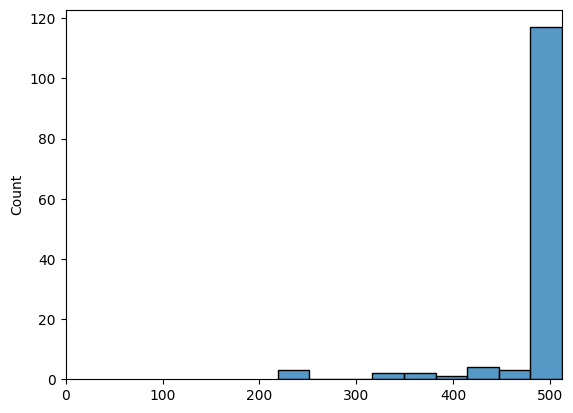

In [16]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [17]:
MAX_TOKEN_COUNT = 512

In [18]:


train_dataset = ArticleDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['article', 'input_ids', 'attention_mask', 'label'])

In [19]:
sample_item

{'article': 'A gyár nettó profitja 439 millió euróra csökkent az elõzõ év harmadik negyedévében elért 903 millió euróhoz képest. Értékesítési árbevétele ezzel szemben 21,2 milliárd euróra emelkedett, ami 2,2 százalékos növekedést jelent.\n\nA német autógyár, amely olyan autómárkákat birtokol, mint az Audi, Seat, Skoda és a VW, nyereségének csökkenését az európai, illetve észak- és dél amerikai piacokon tapasztalható, idõsödõ modelljei iránti keresletcsökkenéssel magyarázta.\n\n(Üzleti Negyed)\n\nAjánlat:\n\nVolkswagen\n\nKorábban:\n\nCsökkentette profit-elõrejelzését a Volkswagen\n(2002. július 30.)',
 'input_ids': tensor([  101,  1037,  1043, 13380,  5658,  3406,  5618,  3900,  4724,  2683,
          4971,  3695,  9944,  2527, 20116,  6559,  7520,  2102, 17207,  3449,
         18153,  2080, 23408,  7386, 17190,  2243, 11265,  6292, 14728,  3726,
         10609,  3449,  8743,  3938,  2509,  4971,  3695,  9944,  6806,  2480,
         17710, 10374,  2102,  1012,  9413, 23125,  2229,  761

In [20]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 30

def create_dataloader(df, tokenizer, max_token_len, batch_size):
    dataset = ArticleDataset(
        df,
        tokenizer=tokenizer,
        max_token_len=max_token_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1
    )

In [21]:
data_loader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_eval = create_dataloader(df_eval, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, return_dict=True, num_labels=number_of_labels)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
accuracy_per_epoch = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_labels = 0
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        correct_labels += (logits.argmax(dim=1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuacy = correct_labels / len(df_train)
    accuracy_per_epoch.append(accuacy)
    print(f"Epoch: {epoch}, Loss: {loss.item()} Accuracy: {accuacy}")

Epoch: 0, Loss: 3.602229595184326 Accuracy: 0.07575757575757576
Epoch: 1, Loss: 3.3442320823669434 Accuracy: 0.06060606060606061
Epoch: 2, Loss: 4.034048080444336 Accuracy: 0.015151515151515152
Epoch: 3, Loss: 3.675258159637451 Accuracy: 0.03787878787878788
Epoch: 4, Loss: 3.088538646697998 Accuracy: 0.045454545454545456
Epoch: 5, Loss: 3.0685713291168213 Accuracy: 0.06818181818181818
Epoch: 6, Loss: 2.8585987091064453 Accuracy: 0.10606060606060606
Epoch: 7, Loss: 2.9035112857818604 Accuracy: 0.11363636363636363
Epoch: 8, Loss: 2.681871175765991 Accuracy: 0.12121212121212122
Epoch: 9, Loss: 2.992171287536621 Accuracy: 0.09848484848484848
Epoch: 10, Loss: 2.713641405105591 Accuracy: 0.10606060606060606
Epoch: 11, Loss: 2.52909517288208 Accuracy: 0.16666666666666666
Epoch: 12, Loss: 2.757678985595703 Accuracy: 0.12878787878787878
Epoch: 13, Loss: 2.1385388374328613 Accuracy: 0.19696969696969696
Epoch: 14, Loss: 2.5283992290496826 Accuracy: 0.1893939393939394
Epoch: 15, Loss: 2.1906692981

In [24]:
accuracy_per_epoch

[0.07575757575757576,
 0.06060606060606061,
 0.015151515151515152,
 0.03787878787878788,
 0.045454545454545456,
 0.06818181818181818,
 0.10606060606060606,
 0.11363636363636363,
 0.12121212121212122,
 0.09848484848484848,
 0.10606060606060606,
 0.16666666666666666,
 0.12878787878787878,
 0.19696969696969696,
 0.1893939393939394,
 0.21212121212121213,
 0.2727272727272727,
 0.25757575757575757,
 0.3712121212121212,
 0.3409090909090909,
 0.4393939393939394,
 0.38636363636363635,
 0.4393939393939394,
 0.5757575757575758,
 0.6136363636363636,
 0.5606060606060606,
 0.696969696969697,
 0.7348484848484849,
 0.7045454545454546,
 0.7348484848484849]

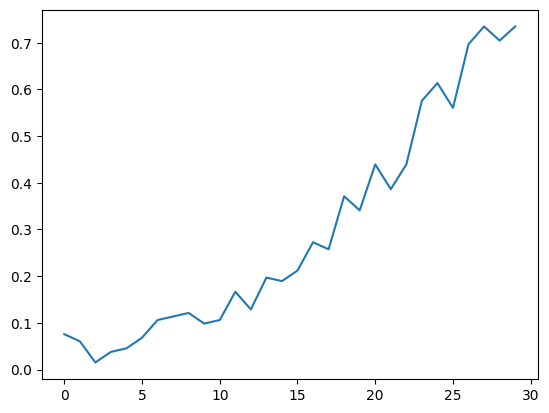

In [27]:
plt.plot(accuracy_per_epoch)

In [25]:
model.eval()
eval_loss = 0
correct_labels = 0

with torch.no_grad():
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        #print(f"{logits})")
        print(f"{logits.argmax(dim=1)} : {labels}")
        correct_labels += (logits.argmax(dim=1) == labels).sum().item()

tensor([0, 0, 0, 0, 0, 0, 1, 1]) : tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([ 1, 20,  1,  1,  2,  2,  2, 13]) : tensor([1, 1, 1, 1, 2, 2, 2, 2])
tensor([ 2,  2, 19, 19, 19, 19, 19, 19]) : tensor([2, 2, 3, 3, 3, 3, 3, 3])
tensor([15, 21, 19, 12, 15, 15,  5,  5]) : tensor([4, 4, 4, 4, 4, 4, 5, 5])
tensor([ 5, 13,  5, 13,  6, 21,  6,  6]) : tensor([5, 5, 5, 5, 6, 6, 6, 6])
tensor([ 6, 21,  7,  7,  7,  7,  7,  7]) : tensor([6, 6, 7, 7, 7, 7, 7, 7])
tensor([8, 8, 8, 8, 8, 8, 9, 9]) : tensor([8, 8, 8, 8, 8, 8, 9, 9])
tensor([ 9,  9,  9,  9, 13, 19, 19, 20]) : tensor([ 9,  9,  9,  9, 10, 10, 10, 10])
tensor([19, 19, 11,  0, 11, 11, 11, 11]) : tensor([10, 10, 11, 11, 11, 11, 11, 11])
tensor([12, 19, 12, 12, 12, 12, 13, 13]) : tensor([12, 12, 12, 12, 12, 12, 13, 13])
tensor([19, 19, 13, 19, 14, 14, 14, 14]) : tensor([13, 13, 13, 13, 14, 14, 14, 14])
tensor([14, 14, 15, 15, 15, 15, 15, 15]) : tensor([14, 14, 15, 15, 15, 15, 15, 15])
tensor([16, 16, 16, 16, 16, 16, 17, 17]) : tensor([16, 16, 16, 1

In [26]:
# Calculate evaluation metrics
eval_len = len(data_loader_train.dataset)
eval_loss /= eval_len
accuracy = correct_labels / eval_len

print(f"Evaluation Loss: {eval_loss}")
print(f"Accuracy: {accuracy}")

Evaluation Loss: 0.2286839990904837
Accuracy: 0.7727272727272727


In [28]:
model_path = 'poltextlab-like-classification-model'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('poltextlab-like-classification-model/tokenizer_config.json',
 'poltextlab-like-classification-model/special_tokens_map.json',
 'poltextlab-like-classification-model/vocab.txt',
 'poltextlab-like-classification-model/added_tokens.json',
 'poltextlab-like-classification-model/tokenizer.json')

In [31]:
# Load saved model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

# Perform inference with the loaded model
inputs = tokenizer("A gyár nettó profitja 439 millió euróra csökkent az elõzõ év harmadik negyedévében elért 903 millió euróhoz képest. Értékesítési árbevétele ezzel szemben 21,2 milliárd euróra emelkedett, ami 2,2 százalékos növekedést jelent."
"A német autógyár, amely olyan autómárkákat birtokol, mint az Audi, Seat, Skoda és a VW, nyereségének csökkenését az európai, illetve észak- és dél amerikai piacokon tapasztalható, idõsödõ modelljei iránti keresletcsökkenéssel magyarázta."
"(Üzleti Negyed)"
"Ajánlat:"
"Volkswagen"
"Korábban:", return_tensors="pt")
outputs = loaded_model(**inputs)
predictions = outputs.logits
id = torch.argmax(predictions, dim=1).item()
print(id_to_label[id])

1
